# Evolution of actors careers post-blockbuster in the film industry

This notebook is dedicated to the matching part of the project.

In [10]:
# Useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## 1. Blockbuster movies
We'll start by defining what makes a movie a big hit (blockbuster). We'll focus on the revenue as mentioned earlier, but also include the IMDb ratings.

We first import the previously preprocessed datasets

In [11]:
# Import preprocessed datasets
%store -r character_movies_filtered_imdb
%store -r nb_tot_filtered_actors

In [12]:
# Make deep copy of our prepared dataset
df_prepared = character_movies_filtered_imdb.copy()

We define the metric for the **success of a movie** as the product of the revenue and the average rating.

In [13]:
# Add a column to our dataset for this new success metric
df_prepared['success'] = df_prepared.revenue * df_prepared.averageRating

We'll examine the **evolution of this metric along the years**.

[]

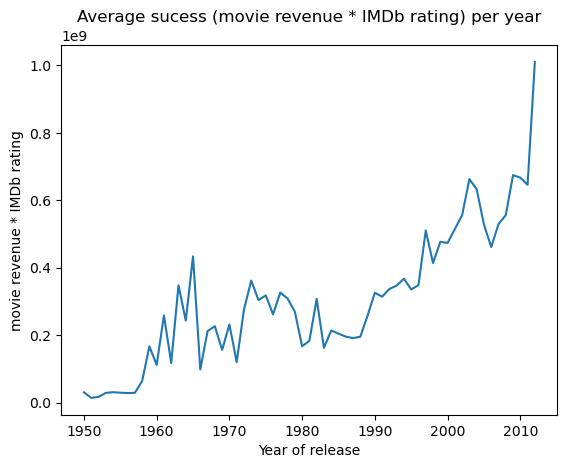

In [14]:
# Drop duplicate movies
unique_movies = df_prepared.drop_duplicates(subset = 'movieID')

# Group by year and success
success_per_year = unique_movies.groupby(by = 'year')['success']

# Get the mean and standard deviation of the success metric for each year
avg_success_per_year = success_per_year.mean()
std_success_per_year = success_per_year.std()

# Plot the results
plt.plot(avg_success_per_year)
plt.title('Average sucess (movie revenue * IMDb rating) per year')
plt.ylabel('movie revenue * IMDb rating')
plt.xlabel('Year of release')
plt.plot()

From this graph we can see a certain fluctuation in the average movie revenue per year.

We'll assume that for a movie to be a big hit it, has to be an **outlier** with respect to our previously defined success metric (product of revenue and average rating). The outliers of each year will be labelled as big hits.

We define an outlier as: 

*outlier's success metric > Q3 + 1.5(IQR)*

where Q1, Q3 and IQR are respectively the first quantile, the third quantile and the interquantile range.

The number of big hits is: 778


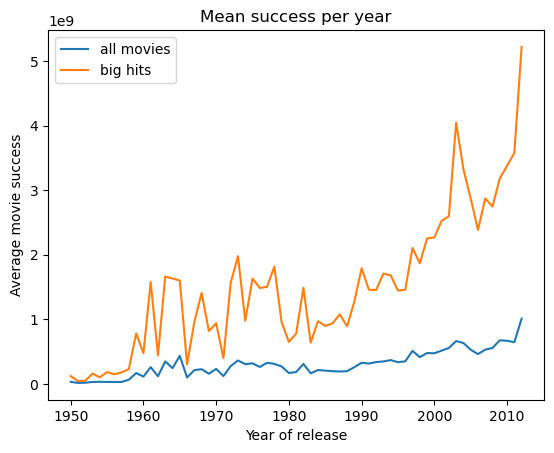

In [15]:
# Compute the first and the third quantile for each year
Q1 = success_per_year.quantile(q=0.25)
Q3 = success_per_year.quantile(q=0.75)

# Compute our ouliner threshold value for each year
outliner_thresh = Q3 + 1.5 *(Q3-Q1)
outliner_thresh.name = 'threshold'

# Filter movie dataset to keep only the big hits
movies_merged = pd.merge(df_prepared, outliner_thresh, left_on='year', right_index=True)
big_hits = movies_merged[movies_merged['success'] > movies_merged['threshold']]

# Plot the mean revenue for big hits compaired to the mean revenue for all movies per year
unique_movie_hits = big_hits.drop_duplicates(subset = 'movieID')
success_hits_per_year = unique_movie_hits.groupby(by = 'year')['success'].mean()

plt.plot(avg_success_per_year, label = 'all movies')
plt.plot(success_hits_per_year, label = 'big hits')

# Add labels
plt.title('Mean success per year')
plt.ylabel('Average movie success')
plt.xlabel('Year of release')
plt.legend()
plt.plot()

# How many big hits do we have?
print(f'The number of big hits is: {len(unique_movie_hits)}')

We now divided our movie set between big hits and moderate success movies.

# 2. Blockbuster actors

Let's divide our actors dataset into the ones that played in a big hit (treatement group) and the ones that did not (control group).

In [16]:
# Get a set with the names of the actors that played in a big hit
unique_actor_hits = big_hits.drop_duplicates(subset = 'name_actor').name_actor

# Creat a new column on our main dataframe, a bool for wheter the actors played in a big hit or not
df_prepared['big_hit_actor'] = df_prepared.name_actor.isin(unique_actor_hits)

# Get a dataframe of actors that played in a big hit (treatement group)
actors_big_hit = df_prepared[df_prepared.big_hit_actor]

# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = df_prepared[~df_prepared.big_hit_actor]

# Print the number of actors in each group
nb_big_hit_actors = len(unique_actor_hits)

print(f'The number of actors that played in a big hit is: {nb_big_hit_actors} (treatement group)')
print(f'The number of actors that did not play in a big hit is: {nb_tot_filtered_actors-nb_big_hit_actors} (control group)')

The number of actors that played in a big hit is: 4894 (treatement group)
The number of actors that did not play in a big hit is: 5107 (control group)


We now have our treatment and control groups. Let's look at the distribution of different features for which we have information.

##### A. Gender
We can first look at the distribution of gender along these 2 groups.

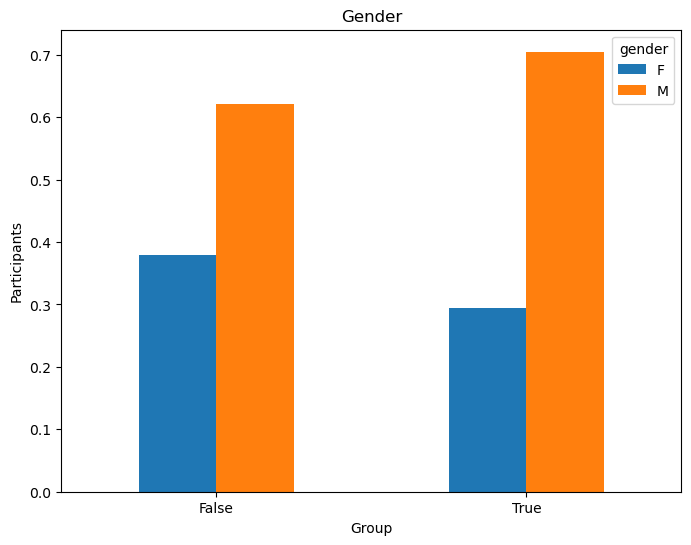

In [17]:
# Grouping the DataFrame 'df_prepared' by 'big_hit_actor' and 'gender', and counting occurrences of 'gender' within each group
group = df_prepared.groupby(['big_hit_actor', 'gender'])['gender'].count()

# Unstacking the grouped data to create a pivot table for easier plotting
group = group.unstack()

# Normalizing the data by dividing each row by the sum of its values to represent proportions
group = group.div(group.sum(axis=1), axis=0)

# Plotting a bar chart using the normalized data with specific formatting
pl = group.plot(kind='bar', figsize=[8,6], rot=0)

pl.set_title('Gender')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()


From this chart, we observe that:
- there are **more men than women** both in blockbusters and less popular movies
- the **difference is even bigger** in blockbusters
- there's a **wider range of success among men** in blockbusters, as shown by the longer error bars
- women's numbers are more stable but **lower overall**

This means that gender could be a key factor to look at when studying the difference between actors in big hits and those in other movies.

##### B. Peak age

Now let's have look at the repartition of the **age at the peak of the actors career**.

We define the **peak of one actor's carrier** by the year where the product of the number of movies played in with their respective success metric is the highest.

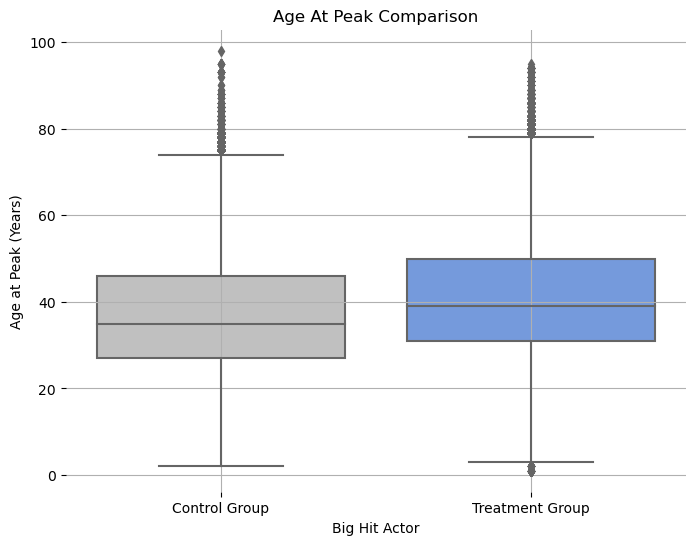

In [18]:
# Calculate the product of the number of movies and respective success metric for each actor and year
df_prepared['product'] = df_prepared.groupby(['name_actor', 'year']).movieID.transform('count') * df_prepared.success

# Find the row with the maximum product for each actor
max_product_rows = df_prepared.loc[df_prepared.groupby('name_actor')['product'].idxmax()]

# Extract the actor and the corresponding year for the maximum product
result = max_product_rows.loc[:, ['name_actor', 'year', 'birth']]

# Correcting the calculation of 'age_at_peak' and merging it into the df_prepared DataFrame
result['age_at_peak'] = result['year'] - result['birth'].dt.year
df_prepared = pd.merge(df_prepared, result[['name_actor', 'age_at_peak']], on='name_actor', how='left')

# Ensuring 'age_at_peak' is calculated correctly
df_prepared['age_at_peak'] = df_prepared['year'] - df_prepared['birth'].dt.year

# Set the figure size and style for better readability
plt.figure(figsize=(8, 6))

# Draw a nested boxplot to show career length by actor type
sns.boxplot(x='big_hit_actor', y='age_at_peak', 
            data=df_prepared, 
            palette=["silver", "cornflowerblue"])

# Customize the plot with titles and labels
plt.grid(True)
plt.title('Age At Peak Comparison')
plt.xlabel('Big Hit Actor')
plt.ylabel('Age at Peak (Years)')
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
# Remove the grid lines for a cleaner look
sns.despine(bottom=True, left=True)

# Show the plot
plt.show()

The boxplot shows that:
- actors in big hits usually hit their peak at an **older age** than those who don't star in big hits
- the ages are more grouped together for big hit actors, while there's a wider spread for the others
- there are quite a few actors who peak at ages that are much higher or lower than average, especially among those without a big hit

The age at peak could also be a good factor to look at when comparing actors in big hits versus others.

## 3. Matching

We'll perform the matching on Gender and Peak age.

##### A. First big hit

We'll first find the **first big hit** of every blockbuster actor. To do this we filter the df_prepared dataframe to obtain all big hit actors with all their associated big hits. We then group the big hits of every blockbuster actor by year and select the first one.

In [20]:
# Remove duplicate rows (actors that had multiple roles in the same movie)
df_prepared = df_prepared.drop_duplicates(subset=['movieID', 'releaseDate', 'name_actor'])

# Define the condition for a movie to be a big hit
df_prepared['is_movie_big_hit'] = df_prepared.movieID.isin(unique_movie_hits.movieID)

# Filter for blockbuster actors and all of their associated big hits
big_hit_actors_df = df_prepared[df_prepared['big_hit_actor'] & df_prepared['is_movie_big_hit']]

# Find the year of the first big hit for each actor
first_big_hit_year = big_hit_actors_df.groupby('name_actor')['releaseDate'].min().reset_index()

# Merge the information back into the original DataFrame
df_prepared = pd.merge(df_prepared, first_big_hit_year, on='name_actor', how='left', suffixes=('', '_first_big_hit'))

##### B. Count of movies

We'll now add the counts of movies an actor played in to our dataframe.

In [25]:
# Count the number of unique movies each actor has played in
movies_per_actor = df_prepared.groupby('name_actor')['movieID'].nunique()

# Convert the series to a dataframe and reset the index
movies_per_actor_df = movies_per_actor.reset_index()
movies_per_actor_df.columns = ['name_actor', 'movie_count']

# Merge with the main DataFrame to associate the movie count with the big_hit_actor bool
df_prepared = df_prepared.merge(movies_per_actor_df, on='name_actor')

##### C. Preparing matching data

We'll now seperate our data into two distinct dataframes:
- a dataframe for the information about peak age, gender and movie counts for actors that played in big hits (treatment group)
- a dataframe for the information about peak age, gender and movie counts for the rest of the actors (control group)

In [27]:
# Create a new DataFrame for big hit actors 
big_hit_actors = df_prepared[df_prepared['big_hit_actor'] == True]

# Group by actor's name and calculate movie count before first big hit
movie_count_before_hit = big_hit_actors.groupby('name_actor').apply(lambda x: x[x['releaseDate'] < x['releaseDate_first_big_hit']]['movieID'].nunique())

# Convert the Series to a DataFrame and reset index
movie_count_before_hit = movie_count_before_hit.reset_index(name='movie_count_before_hit')

# Merge this count back into the original DataFrame
df_prepared = pd.merge(df_prepared, movie_count_before_hit, on='name_actor', how='left')

# Set the count to NaN for actors who are not big hit actors
df_prepared.loc[df_prepared['big_hit_actor'] == False, 'movie_count_before_hit'] = np.nan

# Create a new DataFrame from the drop_duplicates result
unique_actors = df_prepared.drop_duplicates(subset='name_actor').copy()

# Convert the 'big_hit_actor' column to int
unique_actors['big_hit_actor'] = unique_actors['big_hit_actor'].astype(int)

actors_big_hit = unique_actors[unique_actors['big_hit_actor'] == 1][['age_at_peak', 'gender', 'movie_count_before_hit']]

# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = unique_actors[unique_actors['big_hit_actor'] == 0][['age_at_peak', 'gender', 'movie_count']]

##### D. Perform matching

Now that we have the dataframes containing the information about peak age, gender and movie counts for actors that played in big hits, contained in the dataframe actors_big_hit, and for the other actors, contained in the dataframe actors_no_big_hit, we can perform the **matching** between these two groups.

In [29]:
# Resetting the index of the DataFrame 'actors_big_hit' and converting it to a NumPy array
actors_big_hit = actors_big_hit.reset_index()
actors_big_hit_numpy = actors_big_hit.to_numpy()

# Extracting treatment indices from the NumPy array
treat_indices = actors_big_hit_numpy[:, 0]

# Resetting the index of the DataFrame 'actors_no_big_hit' and converting it to a NumPy array
actors_no_big_hit = actors_no_big_hit.reset_index()
actors_no_big_hit_numpy = actors_no_big_hit.to_numpy()

# Extracting control indices from the NumPy array
control_indices = actors_no_big_hit_numpy[:, 0]

# Creating an empty graph using NetworkX
B = nx.Graph()

# Adding nodes for the treatment group to the graph
B.add_nodes_from(treat_indices, bipartite=0)

# Adding nodes for the control group to the graph
B.add_nodes_from(control_indices, bipartite=1)

# Threshold for the condition to add an edge between treatment and control nodes
th = 3

# Iterating over rows in the treatment and control groups to add edges based on specified conditions
for t_row in actors_big_hit_numpy:
    for c_row in actors_no_big_hit_numpy:
        if abs(t_row[1] - c_row[1]) <= 10 and t_row[2] == c_row[2] and c_row[3] - t_row[3] >= th:
            # Adding an edge between treatment and control nodes with the total cost as weight
            B.add_edge(t_row[0], c_row[0], weight=0)

# Finding the minimum weight matching in the bipartite graph using NetworkX
matching = nx.algorithms.matching.min_weight_matching(B)

We'll store the values from the matching in a dataframe matched_df to analyse it

In [30]:
# Creating a new DataFrame to store the matched pairs with names
matched_df = pd.DataFrame(columns=['control_index', 'name_actor_control', 'treat_index', 'name_actor_treat'])

for control_idx, treatment_idx in matching:
    control_name = unique_actors.loc[control_idx]['name_actor']
    treatment_name = unique_actors.loc[treatment_idx]['name_actor']
    new_row = pd.DataFrame({
        'control_index': control_idx,
        'name_actor_control': control_name,
        'treat_index': treatment_idx,
        'name_actor_treat': treatment_name
    }, index=[0])
    matched_df = pd.concat([matched_df, new_row], axis=0, ignore_index=True)

matched_df

,control_index,name_actor_control,treat_index,name_actor_treat
0,19814,Jonathan Cherry,38716,James Read
1,44183,Zachary Gordon,49915,Adam Wylie
2,52449,Brian Tarantina,43814,Tom Towles
3,38852,Seychelle Gabriel,49247,Analeigh Tipton
4,54974,Leland Orser,25435,Joe Regalbuto
...,...,...,...,...
2599,32301,Jim Backus,40271,Jeffrey Wright
2600,48126,Cesare Danova,43934,Billy Ray Cyrus
2601,56560,Frances O'Connor,58737,Margarita Levieva
2602,40181,David Ramsey,47955,Charles Dierkop


Finally, we'll selecting the rows from 'unique_actors' based on the matched indices

In [31]:
# Extracting the matched indices from the minimum weight matching and combining them into a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

# Creating a new DataFrame 'balanced_df' by selecting rows from 'unique_actors' based on the matched indices
balanced_df = unique_actors.loc[matched]

The values from the matching will be stored in order to be accessible in other notebooks.

In [32]:
%store balanced_df
%store df_prepared
%store matched_df

Stored 'balanced_df' (DataFrame)
Stored 'df_prepared' (DataFrame)
Stored 'matched_df' (DataFrame)
